<a href="https://colab.research.google.com/github/JhaAkansha/SnowCapMeltAnalysis/blob/main/RS_OEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install earthengine-api geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.9 MB/s eta 0:00:00


In [48]:
pip install folium

In [1]:
import ee
ee.Authenticate()
ee.Initialize(project='snowcapmelt')

In [24]:
import datetime
import matplotlib.pyplot as plt

# Arctic and Antarctic regions
arctic = ee.Geometry.Point([-45, 69]).buffer(100000)
antarctic = ee.Geometry.Point([-63.5, -73]).buffer(100000)

# NDSI calculation function
def calculate_ndsi(image, green_band, swir_band):
    ndsi = image.normalizedDifference([green_band, swir_band]).rename('NDSI')
    return image.addBands(ndsi)

# Safe median for empty image collections
def safe_median(img_collection):
    size = img_collection.size()
    return ee.Image(ee.Algorithms.If(
        size.eq(0),
        ee.Image(0),  # fallback
        img_collection.median()
    ))

# Main function to compute yearly snow cover
def get_yearly_snow_cover(start_year, end_year, region, platform='Landsat'):
    yearly_snow_stats = []

    for year in range(start_year, end_year + 1):
        start = ee.Date.fromYMD(year, 6, 1)
        end = ee.Date.fromYMD(year, 9, 30)

        if platform == 'Landsat':
            # Filter collections
            l5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2") \
                .filterDate(start, end).filterBounds(region)
            l7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2") \
                .filterDate(start, end).filterBounds(region)
            l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
                .filterDate(start, end).filterBounds(region)
            l9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
                .filterDate(start, end).filterBounds(region)

            # Merge all
            merged = l5.merge(l7).merge(l8).merge(l9)

            # Apply NDSI using SR_B3 (green) and SR_B7 (SWIR for Landsat 5/7/8/9)
            processed = merged.map(lambda img: calculate_ndsi(img, 'SR_B3', 'SR_B7'))

        else:
            raise ValueError("Only Landsat supported for now.")

        # Threshold NDSI to get snow
        snow_ndsi = processed.map(lambda img: img.select('NDSI').gt(0.4))

        # Handle empty collection with safe median
        snow_masked = safe_median(snow_ndsi)

        # Multiply snow mask by pixel area
        pixel_area = snow_masked.multiply(ee.Image.pixelArea())

        # Reduce to get total snow-covered area in the region
        stats = pixel_area.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=region,
            scale=30,
            maxPixels=1e13
        )

        # Safely extract snow-covered area in km²
        snow_value = ee.Algorithms.If(
            stats.contains('NDSI'),
            ee.Number(stats.get('NDSI')).divide(1e6),
            0
        )

        yearly_snow_stats.append(snow_value)

    return ee.List(yearly_snow_stats)

# === RUNNING FOR ARCTIC AND ANTARCTIC === #
years = list(range(2000, 2025))

print("Calculating Arctic snow cover...")
arctic_snow = get_yearly_snow_cover(2000, 2024, arctic, platform='Landsat')
arctic_area = arctic_snow.getInfo()  # converts ee.List to Python list

print("Calculating Antarctic snow cover...")
antarctic_snow = get_yearly_snow_cover(2000, 2024, antarctic, platform='Landsat')
antarctic_area = antarctic_snow.getInfo()
print("Arctic Snow Area (km²):", arctic_area)
print("Antarctic Snow Area (km²):", antarctic_area)

Calculating Arctic snow cover...
Calculating Antarctic snow cover...
Arctic Snow Area (km²): [11572.203509698358, 11503.952528084863, 11585.101621871609, 9820.419660450183, 11510.572300487429, 9497.523122354683, 11697.68416731777, 11675.539237948286, 11367.18616914419, 11839.847575026024, 12802.946528815413, 12639.477811680374, 12638.870749817104, 13291.38025356888, 12858.674828907719, 12887.095098216574, 13010.43737340373, 12894.582256850588, 13111.571094806384, 12985.646817845318, 12938.138253421708, 12996.438059993206, 12980.568057927965, 12920.876506075194, 13014.287790172728]
Antarctic Snow Area (km²): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


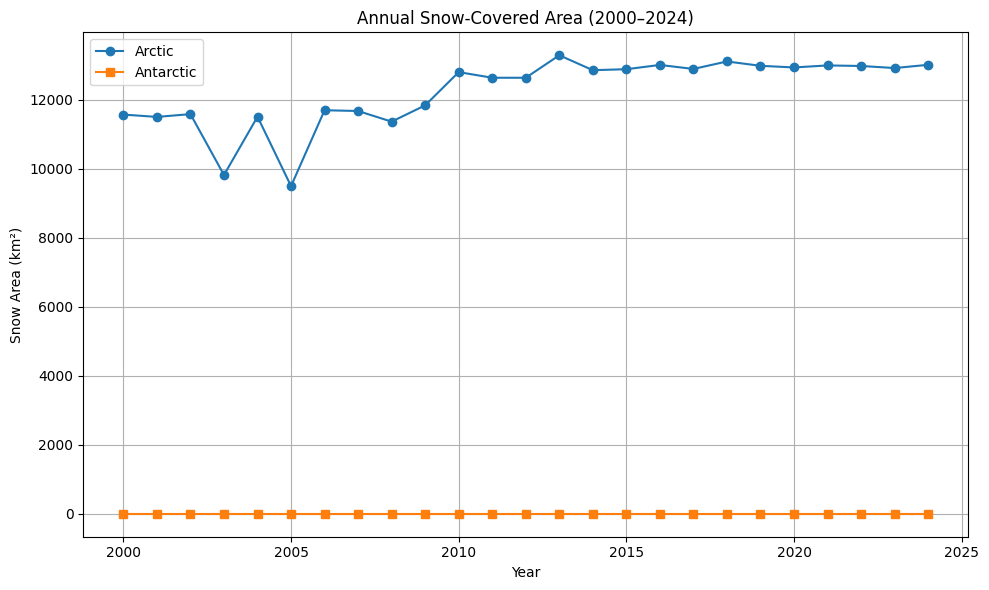

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(years, arctic_area, label='Arctic', marker='o')
plt.plot(years, antarctic_area, label='Antarctic', marker='s')
plt.title("Annual Snow-Covered Area (2000–2024)")
plt.ylabel("Snow Area (km²)")
plt.xlabel("Year")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Processing 2015...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2016...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2017...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2018...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2019...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2020...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2021...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2022...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2023...
  Greenland...OK
  S

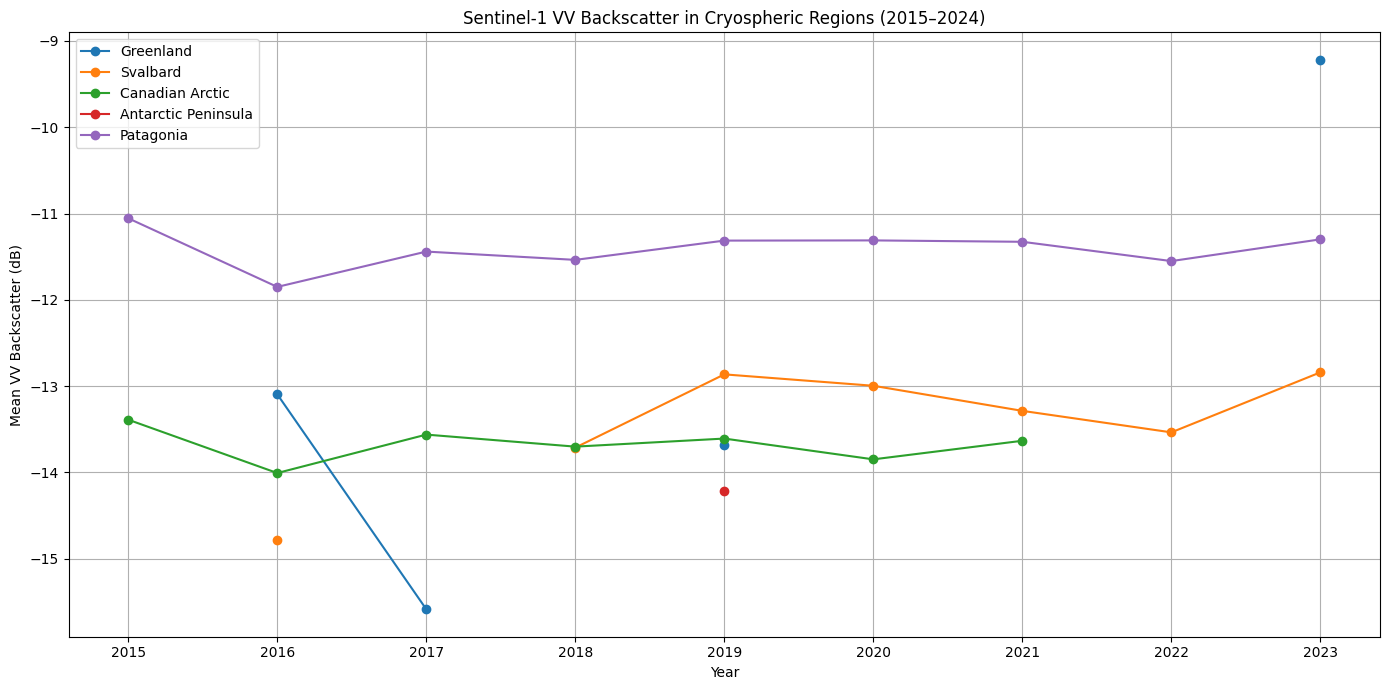

In [43]:
#Mean VV backscatter (dB)	Higher = dry snow or ice, Lower = wet/melted

# Define regions as polygons
regions = {
    'Greenland': ee.Geometry.Polygon([[[-52, 60], [-52, 80], [-30, 80], [-30, 60], [-52, 60]]]),
    'Svalbard': ee.Geometry.Polygon([[[10, 76], [10, 82], [35, 82], [35, 76], [10, 76]]]),
    'Canadian Arctic': ee.Geometry.Polygon([[[-100, 65], [-100, 75], [-70, 75], [-70, 65], [-100, 65]]]),
    'Antarctic Peninsula': ee.Geometry.Polygon([[[-75, -75], [-75, -60], [-50, -60], [-50, -75], [-75, -75]]]),
    'Patagonia': ee.Geometry.Polygon([[[-75, -55], [-75, -45], [-70, -45], [-70, -55], [-75, -55]]]),
}

# Years to analyze
years = list(range(2015, 2024))

# Get Sentinel-1 VV backscatter
def get_s1_vv_mean(region, year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = ee.Date.fromYMD(year, 12, 31)

    s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterDate(start, end) \
        .filterBounds(region) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .select('VV')

    if s1.size().getInfo() == 0:
        return None

    median = s1.median().clip(region)
    stats = median.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=5000,
        maxPixels=1e13,
        tileScale=8
    )
    return stats.get('VV').getInfo()

# Results dictionary
results = {name: [] for name in regions.keys()}

# Process each region
for year in years:
    print(f"\nProcessing {year}...")
    for name, geom in regions.items():
        try:
            print(f"  {name}...", end='')
            vv = get_s1_vv_mean(geom, year)
            results[name].append(vv)
            print("OK")
        except Exception as e:
            print(f"error ({e})")
            results[name].append(None)

# ---- Plot results ----
plt.figure(figsize=(14, 7))
for name, values in results.items():
    plt.plot(years, values, marker='o', label=name)

plt.title('Sentinel-1 VV Backscatter in Cryospheric Regions (2015–2024)')
plt.xlabel('Year')
plt.ylabel('Mean VV Backscatter (dB)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
import geemap
dataset = ee.ImageCollection('MODIS/061/MOD10A1').filter(ee.Filter.date('2000-04-01', '2000-05-01'));
snowCover_2000 = dataset.select('NDSI_Snow_Cover');
snowCoverVis = {
  'min': 0.0,
  'max': 100.0,
  'palette': ['black', '0dffff', '0524ff', 'ffffff'],
};
Map2000 = geemap.Map(center=[-41.13, 76.35], zoom=3)
Map2000.setCenter(-41.13, 76.35, 3);
Map2000.addLayer(snowCover_2000, snowCoverVis, 'Snow Cover');
Map2000

Map(center=[76.35, -41.13], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

In [55]:
dataset = ee.ImageCollection('MODIS/061/MOD10A1').filter(ee.Filter.date('2024-04-01', '2024-05-01'));
snowCover_2024 = dataset.select('NDSI_Snow_Cover');
snowCoverVis = {
  'min': 0.0,
  'max': 100.0,
  'palette': ['black', '0dffff', '0524ff', 'ffffff'],
};
Map2024 = geemap.Map(center=[-41.13, 76.35], zoom=3)
Map2024.setCenter(-41.13, 76.35, 3);
Map2024.addLayer(snowCover_2024, snowCoverVis, 'Snow Cover');
Map2024

Map(center=[76.35, -41.13], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

In [56]:
snowCover_2000 = snowCover_2000.mean()
snowCover_2024 = snowCover_2024.mean()
difference = snowCover_2024.subtract(snowCover_2000)

# Visualization parameters for the difference
differenceVis = {
    'min': -100.0,
    'max': 100.0,
    'palette': ['blue', 'white', 'red'],
}
MapDiff = geemap.Map(center=[76.35, -41.13], zoom=3)
# Add the difference map
MapDiff.addLayer(difference, differenceVis, 'Snow Cover Difference (2024 - 2000)')
MapDiff
#red shows a decrease in the snow cover while blue shows an increase

Map(center=[76.35, -41.13], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

In [ ]:
#Landsat does not cover most of the Antarctic interior due to orbital constraints.
#most imagery is cloud-covered or unavailable during Antarctic winter.

In [ ]:
#Sentinel 1 is not optical and therefore does not give NDSI hence we use backscatter

In [5]:
#Getting data for 2000 to 2014 from MODIS since Sentinel-1 does not have data before 2015
#MODIS gives fraction of area snow-covered: 0 (none) to 1 (fully covered). Sentinel-1 VV gives backscatter (dB): useful for wet snow / ice transitions.


Processing: Greenland
  Year 2000...OK
  Year 2001...

/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MOD10A1! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD10A1

  warnings.warn(warning, category=DeprecationWarning)


OK
  Year 2002...OK
  Year 2003...OK
  Year 2004...OK
  Year 2005...OK
  Year 2006...OK
  Year 2007...OK
  Year 2008...OK
  Year 2009...OK
  Year 2010...OK
  Year 2011...OK
  Year 2012...OK
  Year 2013...OK
  Year 2014...OK
  Year 2015...—
  Year 2016...—
  Year 2017...—
  Year 2018...—
  Year 2019...—
  Year 2020...—
  Year 2021...—
  Year 2022...—
  Year 2023...—
  Year 2024...—

Processing: Svalbard
  Year 2000...OK
  Year 2001...OK
  Year 2002...OK
  Year 2003...OK
  Year 2004...OK
  Year 2005...OK
  Year 2006...OK
  Year 2007...OK
  Year 2008...OK
  Year 2009...OK
  Year 2010...OK
  Year 2011...OK
  Year 2012...OK
  Year 2013...OK
  Year 2014...OK
  Year 2015...—
  Year 2016...—
  Year 2017...—
  Year 2018...OK
  Year 2019...OK
  Year 2020...OK
  Year 2021...OK
  Year 2022...OK
  Year 2023...OK
  Year 2024...OK

Processing: Canadian Arctic
  Year 2000...OK
  Year 2001...OK
  Year 2002...OK
  Year 2003...OK
  Year 2004...OK
  Year 2005...OK
  Year 2006...OK
  Year 2007...OK
  Year 

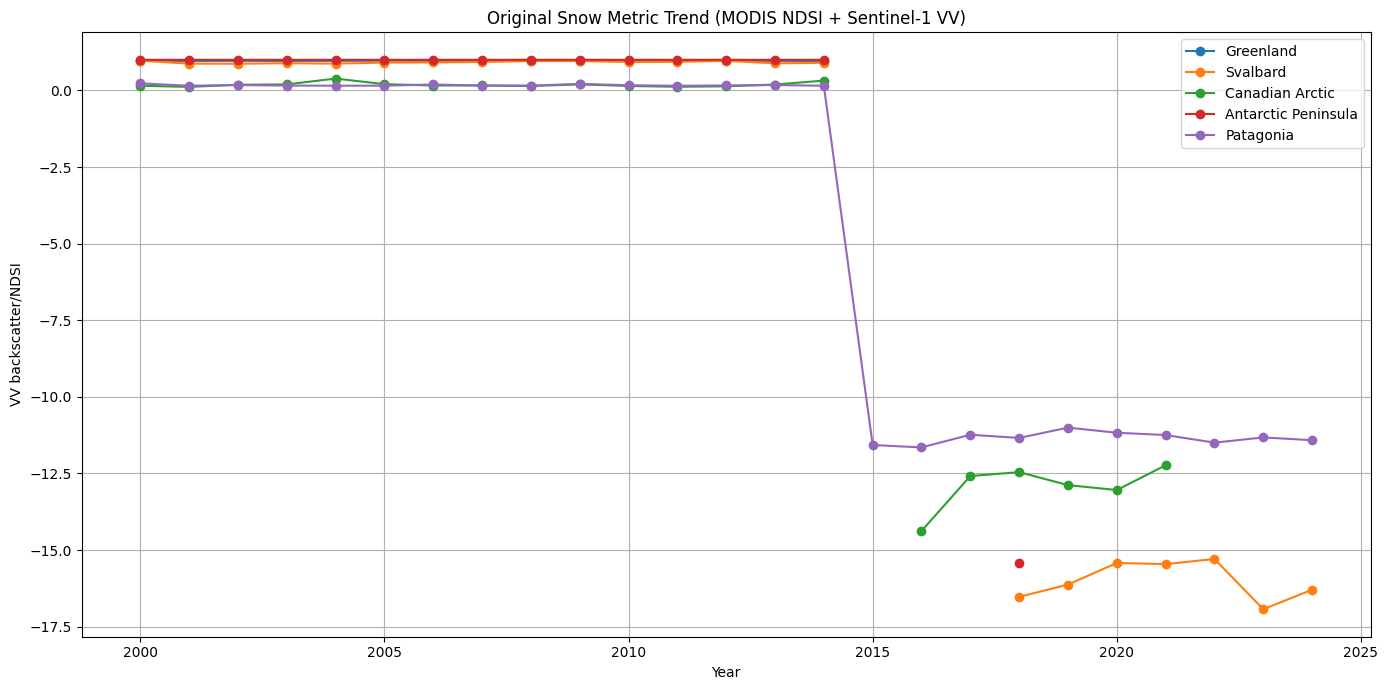

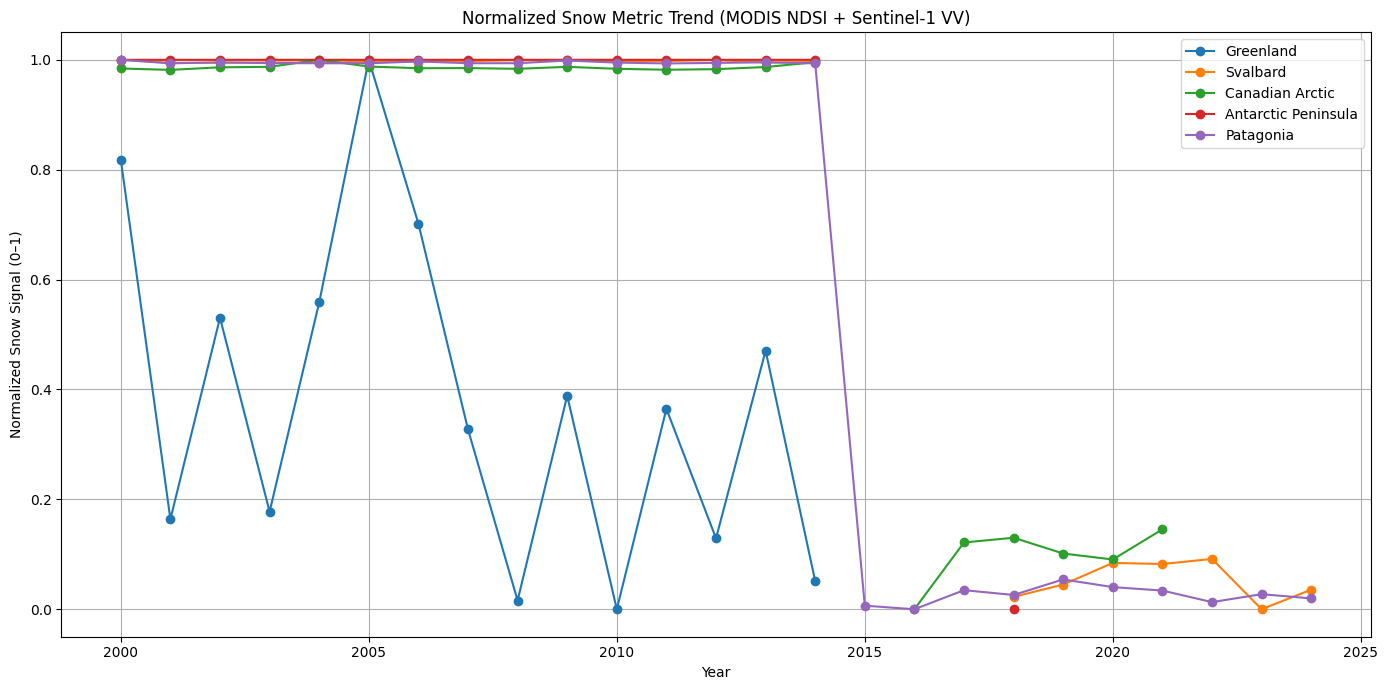

In [4]:
import ee
import matplotlib.pyplot as plt
import numpy as np

# Define regions
regions = {
    'Greenland': ee.Geometry.Polygon([[[-52, 60], [-52, 80], [-30, 80], [-30, 60], [-52, 60]]]),
    'Svalbard': ee.Geometry.Polygon([[[10, 76], [10, 82], [35, 82], [35, 76], [10, 76]]]),
    'Canadian Arctic': ee.Geometry.Polygon([[[-100, 65], [-100, 75], [-70, 75], [-70, 65], [-100, 65]]]),
    'Antarctic Peninsula': ee.Geometry.Polygon([[[-75, -75], [-75, -60], [-50, -60], [-50, -75], [-75, -75]]]),
    'Patagonia': ee.Geometry.Polygon([[[-75, -55], [-75, -45], [-70, -45], [-70, -55], [-75, -55]]]),
}

# Years to process
years = list(range(2000, 2025))

# Function to get snow metric
def get_snow_metric(region_geom, year, region_name):
    try:
        # Set season per hemisphere
        if region_name.lower().startswith('antarctic') or region_name == 'Patagonia':
            start = f'{year}-12-01'
            end = f'{year+1}-02-28'
        else:
            start = f'{year}-06-15'
            end = f'{year}-08-15'

        # MODIS if year < 2015
        if year < 2015:
            # MODIS with cloud masking and median composite
            modis = ee.ImageCollection('MODIS/006/MOD10A1') \
            .filterDate(start, end) \
            .filterBounds(region_geom) \
            .select(['NDSI_Snow_Cover', 'NDSI_Snow_Cover_Basic_QA'])

            # Cloud mask function
            def mask_modis_clouds(img):
              qa = img.select('NDSI_Snow_Cover_Basic_QA')
              snow = img.select('NDSI_Snow_Cover')
              # Keep pixels where QC = 0 (best quality)
              mask = qa.eq(0)
              # Create a binary snow presence band
              snow_bin = snow.gt(0).rename('snow')
              return snow_bin.updateMask(mask)
            # Apply mask and compute median composite
            snow_masked = modis.map(mask_modis_clouds).median()
            # Reduce to mean snow cover presence
            stats = snow_masked.reduceRegion(
              reducer=ee.Reducer.mean(),
              geometry=region_geom,
              scale=5000,
              maxPixels=1e13,
              tileScale=4
            )
            return stats.get('snow').getInfo()


        # Speckle filter function
        def speckle_filter(image):
          kernel = ee.Kernel.square(radius=1)
          return image.convolve(kernel).copyProperties(image, image.propertyNames())

        # Sentinel-1 VV fallback (SAR)
        s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterDate(start, end) \
        .filterBounds(region_geom) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .select('VV') \
        .map(speckle_filter)


        if s1.size().getInfo() == 0:
            return None

        median = s1.median().clip(region_geom)
        stats = median.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region_geom,
            scale=5000,
            maxPixels=1e13,
            tileScale=4
        )
        value = stats.get('VV')
        return value.getInfo() if value else None

    except Exception as e:
        print(f"  Error {region_name} {year} failed: {e}")
        return None


# Run the analysis
results = {}
for region_name, region_geom in regions.items():
    print(f"\nProcessing: {region_name}")
    region_results = []
    for year in years:
        print(f"  Year {year}...", end="")
        val = get_snow_metric(region_geom, year, region_name)
        region_results.append(val)
        print("OK" if val is not None else "—")
    results[region_name] = region_results

#Plot results
plt.figure(figsize=(14, 7))
for region_name, values in results.items():
    # Only plot if at least one value is valid
    if any(v is not None and not np.isnan(v) for v in values):
        cleaned = [v if v is not None else np.nan for v in values]
        print(region_name, ": ", cleaned)
        plt.plot(years, cleaned, label=region_name, marker='o')
plt.title("Original Snow Metric Trend (MODIS NDSI + Sentinel-1 VV)")
plt.xlabel("Year")
plt.ylabel("VV backscatter/NDSI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Normalize data between 0 and 1 for each region
def normalize(series):
    arr = np.array([v if v is not None else np.nan for v in series])
    min_val = np.nanmin(arr)
    max_val = np.nanmax(arr)
    return [(v - min_val) / (max_val - min_val) if v is not None else np.nan for v in arr]

plt.figure(figsize=(14, 7))
for region_name, values in results.items():
    if any(v is not None for v in values):
        norm_vals = normalize(values)
        plt.plot(years, norm_vals, label=region_name, marker='o')

plt.title("Normalized Snow Metric Trend (MODIS NDSI + Sentinel-1 VV)")
plt.xlabel("Year")
plt.ylabel("Normalized Snow Signal (0–1)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [97]:
def get_snow(region_geom, year, region_name):
    try:
        # Set season per hemisphere
        if region_name.lower().startswith('antarctic') or region_name == 'Patagonia':
            start = f'{year}-12-01'
            end = f'{year+1}-02-28'
        else:
            start = f'{year}-06-15'
            end = f'{year}-08-15'

        # MODIS if year < 2015
        if year < 2015:
            # MODIS with cloud masking and median composite
            modis = ee.ImageCollection('MODIS/006/MOD10A1') \
            .filterDate(start, end) \
            .filterBounds(region_geom) \
            .select(['NDSI_Snow_Cover', 'NDSI_Snow_Cover_Basic_QA'])

            # Check if the collection is empty
            if modis.size().getInfo() == 0:
                print(f"No MODIS data for {region_name} in {year}.")
                return None

            # Cloud mask function
            def mask_modis_clouds(img):
                qa = img.select('NDSI_Snow_Cover_Basic_QA')
                snow = img.select('NDSI_Snow_Cover')
                # Keep pixels where QC = 0 (best quality)
                mask = qa.eq(0)
                # Create a binary snow presence band
                snow_bin = snow.gt(0).rename('snow')
                return snow_bin.updateMask(mask)

            # Apply mask and compute median composite
            snow_masked = modis.map(mask_modis_clouds).median()

            # Return the snow image itself for visualization
            return snow_masked.clip(region_geom)

        # Speckle filter function
        def speckle_filter(image):
            kernel = ee.Kernel.square(radius=1)
            return image.convolve(kernel).copyProperties(image, image.propertyNames())

        # Sentinel-1 VV fallback (SAR)
        s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
            .filterDate(start, end) \
            .filterBounds(region_geom) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
            .filter(ee.Filter.eq('instrumentMode', 'IW')) \
            .select('VV') \
            .map(speckle_filter)

        # Check if the Sentinel-1 collection is empty
        if s1.size().getInfo() == 0:
            print(f"No Sentinel-1 data for {region_name} in {year}.")
            return None

        median = s1.median().clip(region_geom)

        # Return the image itself for visualization
        return median

    except Exception as e:
        print(f"  Error {region_name} {year} failed: {e}")
        return None
# Function to visualize the image on a map
def visualize_on_map(image, region_geom, region_name, year):
    # Get the Map ID for visualization in folium
    try:
        map_id_dict = image.getMapId({
            'min': 0, 'max': 1, 'palette': ['white', 'blue', 'green']
        })

        # Display map with folium
        map_ = folium.Map(location=[region_geom.centroid().getInfo()['coordinates'][1],
                                    region_geom.centroid().getInfo()['coordinates'][0]], zoom_start=5)

        # Add image to the map
        folium.TileLayer(
            tiles=map_id_dict['tile_fetcher'].url_format,
            attr='Google Earth Engine',
            overlay=True,
            name=f'{region_name} {year}'
        ).add_to(map_)

        return map_
    except Exception as e:
        print(f"Error visualizing map: {e}")
        return None

# Run the analysis and visualize for a specific region and year
region_name = 'Greenland'
region_geom = regions['Greenland']
year = 2005

# Get the snow metric (MODIS or Sentinel-1 image)
snow_image = get_snow(region_geom, year, region_name)

# If a valid image is returned, visualize it
if snow_image:
    map_output = visualize_on_map(snow_image, region_geom, region_name, year)
    if map_output:
        map_output  # This will render the map
else:
    print(f"No valid image for {region_name} in {year}.")
map_output

Processing years: 100%|██████████| 25/25 [19:40<00:00, 47.21s/it]


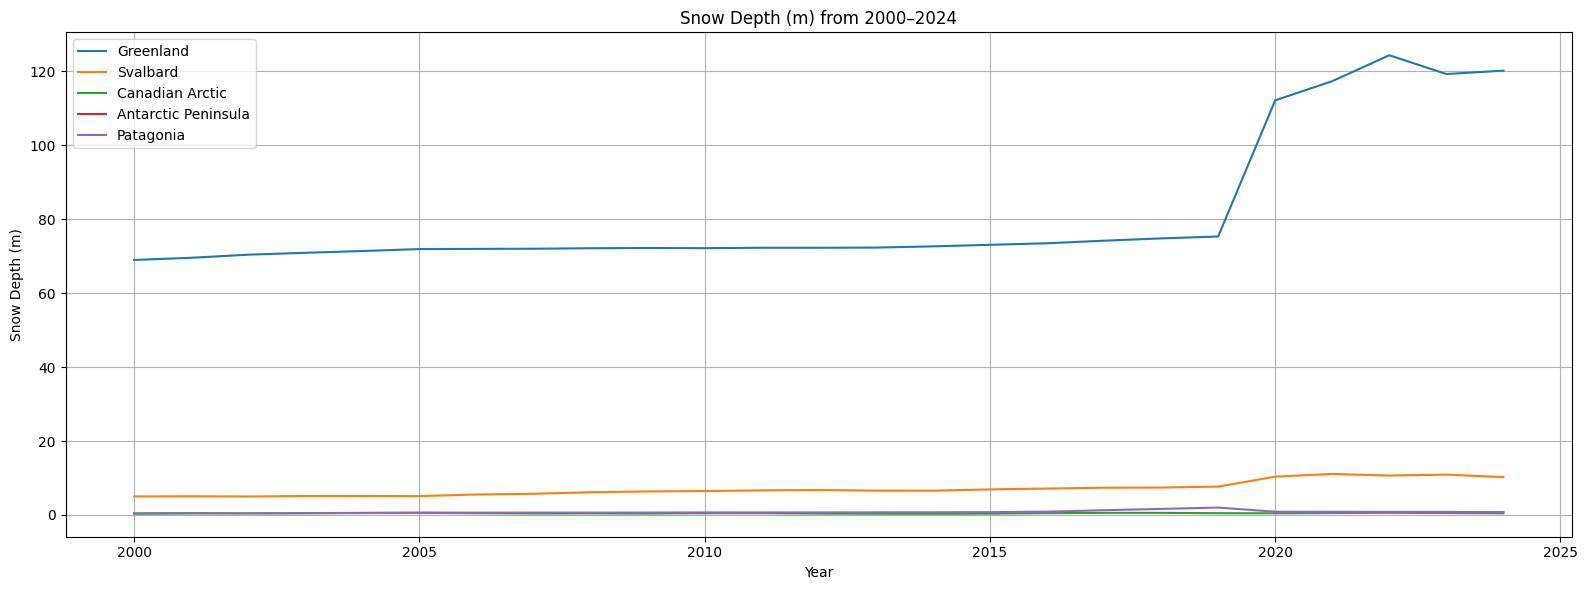

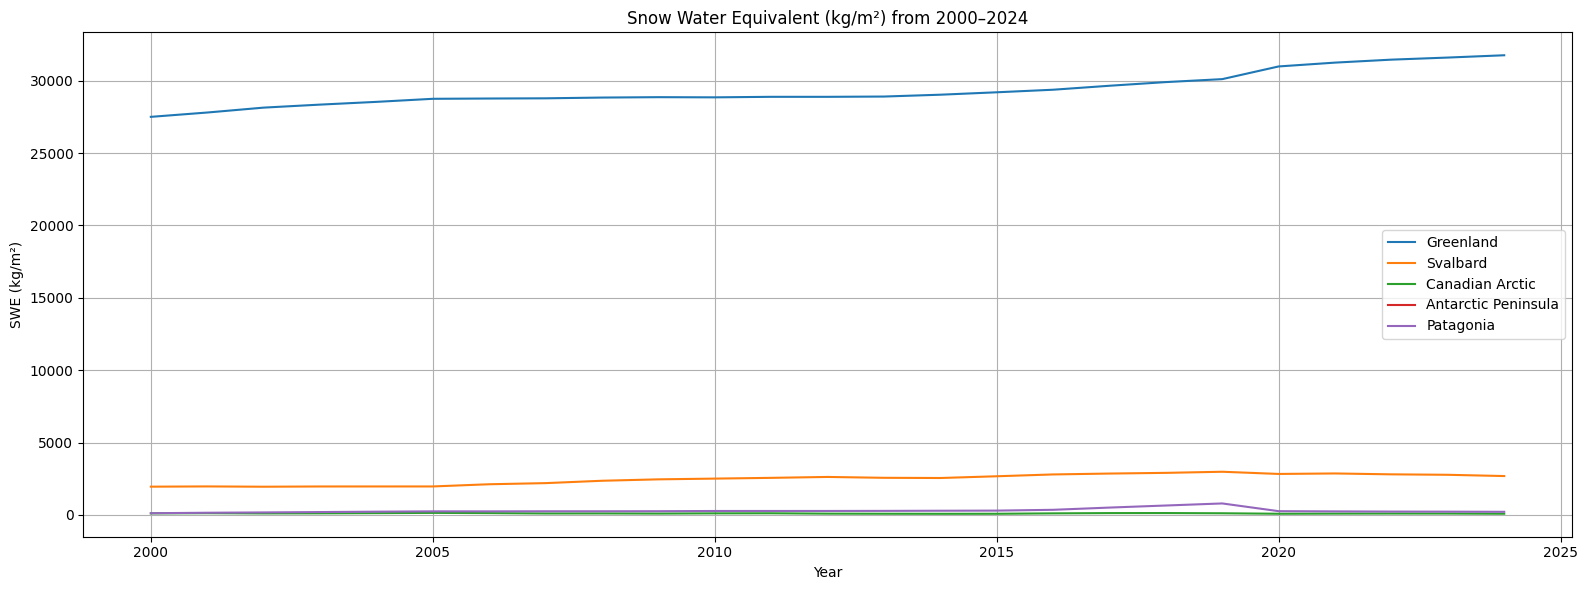

In [11]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define regions
regions = {
    'Greenland': ee.Geometry.Polygon([[[-52, 60], [-52, 80], [-30, 80], [-30, 60], [-52, 60]]]),
    'Svalbard': ee.Geometry.Polygon([[[10, 76], [10, 82], [35, 82], [35, 76], [10, 76]]]),
    'Canadian Arctic': ee.Geometry.Polygon([[[-100, 65], [-100, 75], [-70, 75], [-70, 65], [-100, 65]]]),
    'Antarctic Peninsula': ee.Geometry.Polygon([[[-75, -75], [-75, -60], [-50, -60], [-50, -75], [-75, -75]]]),
    'Patagonia': ee.Geometry.Polygon([[[-75, -55], [-75, -45], [-70, -45], [-70, -55], [-75, -55]]]),
}

# Years to analyze
years = list(range(2000, 2025))

# Initialize dataframe to store results
data = []

# Loop through years and regions
for year in tqdm(years, desc="Processing years"):
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'

    # Load dataset for the year
    gldas = ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H') \
        .filterDate(start_date, end_date) \
        .select(['SnowDepth_inst', 'SWE_inst']) \
        .mean()

    for region_name, geom in regions.items():
        try:
            stats = gldas.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geom,
                scale=25000,
                maxPixels=1e13
            ).getInfo()

            data.append({
                'Year': year,
                'Region': region_name,
                'SnowDepth_m': stats.get('SnowDepth_inst'),
                'SWE_kg_per_m2': stats.get('SWE_inst')
            })

        except Exception as e:
            print(f"Failed for {region_name} in {year}: {e}")
            data.append({
                'Year': year,
                'Region': region_name,
                'SnowDepth_m': None,
                'SWE_kg_per_m2': None
            })

# Create DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(16, 6))
for region in df['Region'].unique():
    region_df = df[df['Region'] == region]
    plt.plot(region_df['Year'], region_df['SnowDepth_m'], label=region)

plt.title("Snow Depth (m) from 2000–2024")
plt.xlabel("Year")
plt.ylabel("Snow Depth (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# SWE plot
plt.figure(figsize=(16, 6))
for region in df['Region'].unique():
    region_df = df[df['Region'] == region]
    plt.plot(region_df['Year'], region_df['SWE_kg_per_m2'], label=region)

plt.title("Snow Water Equivalent (kg/m²) from 2000–2024")
plt.xlabel("Year")
plt.ylabel("SWE (kg/m²)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
print(df)

     Year               Region  SnowDepth_m  SWE_kg_per_m2
0    2000            Greenland    68.961802   27506.077148
1    2000             Svalbard     5.011192    1952.154577
2    2000      Canadian Arctic     0.437547     106.025994
3    2000  Antarctic Peninsula          NaN            NaN
4    2000            Patagonia     0.322587     117.033365
..    ...                  ...          ...            ...
120  2024            Greenland   120.165501   31762.102815
121  2024             Svalbard    10.231121    2685.432920
122  2024      Canadian Arctic     0.456857      81.753573
123  2024  Antarctic Peninsula          NaN            NaN
124  2024            Patagonia     0.786732     214.503735

[125 rows x 4 columns]


In [22]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define regions
regions = {
    'Greenland': ee.Geometry.Polygon([[[-52, 60], [-52, 80], [-30, 80], [-30, 60], [-52, 60]]]),
    'Svalbard': ee.Geometry.Polygon([[[10, 76], [10, 82], [35, 82], [35, 76], [10, 76]]]),
    'Canadian Arctic': ee.Geometry.Polygon([[[-100, 65], [-100, 75], [-70, 75], [-70, 65], [-100, 65]]]),
    'Antarctic Peninsula': ee.Geometry.Polygon([[[-75, -75], [-75, -60], [-50, -60], [-50, -75], [-75, -75]]]),
    'Patagonia': ee.Geometry.Polygon([[[-75, -55], [-75, -45], [-70, -45], [-70, -55], [-75, -55]]]),
}

years = list(range(2000, 2025))
data = []

for year in tqdm(years, desc="Processing MERRA-2 data"):
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'

    # Load MERRA-2
    merra = ee.ImageCollection('NASA/GSFC/MERRA/aer/2') \
        .filterDate(start_date, end_date) \
        .select(['BCSMASS', 'DMSCMASS']) \
        .mean()

    for region_name, geom in regions.items():
        try:
            stats = merra.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geom,
                scale=50000,  # MERRA-2 resolution is coarser (~50km)
                maxPixels=1e13
            ).getInfo()

            data.append({
                'Year': year,
                'Region': region_name,
                'SnowDepth_m': stats.get('BCSMASS'),
                'SWE_kg_per_m2': stats.get('DMSCMASS')
            })

        except Exception as e:
            print(f"⚠️ Failed for {region_name} in {year}: {e}")
            data.append({
                'Year': year,
                'Region': region_name,
                'SnowDepth_m': None,
                'SWE_kg_per_m2': None
            })

# Build DataFrame
merra_df = pd.DataFrame(data)

Processing MERRA-2 data: 100%|██████████| 25/25 [53:55<00:00, 129.42s/it]


NameError: name 'mera_df' is not defined

<Figure size 1600x600 with 0 Axes>

In [32]:
print(merra_df)

     Year               Region   SnowDepth_m  SWE_kg_per_m2
0    2000            Greenland  2.204616e-11   2.485234e-08
1    2000             Svalbard  2.536323e-11   7.056868e-08
2    2000      Canadian Arctic  2.789376e-11   8.954251e-09
3    2000  Antarctic Peninsula  1.615286e-12   2.406827e-07
4    2000            Patagonia  7.189279e-12   2.276385e-07
..    ...                  ...           ...            ...
120  2024            Greenland  3.447454e-11   2.465703e-08
121  2024             Svalbard  2.986946e-11   9.917772e-08
122  2024      Canadian Arctic  5.793111e-11   9.866819e-09
123  2024  Antarctic Peninsula  2.975570e-12   2.440416e-07
124  2024            Patagonia  1.265146e-11   1.883533e-07

[125 rows x 4 columns]


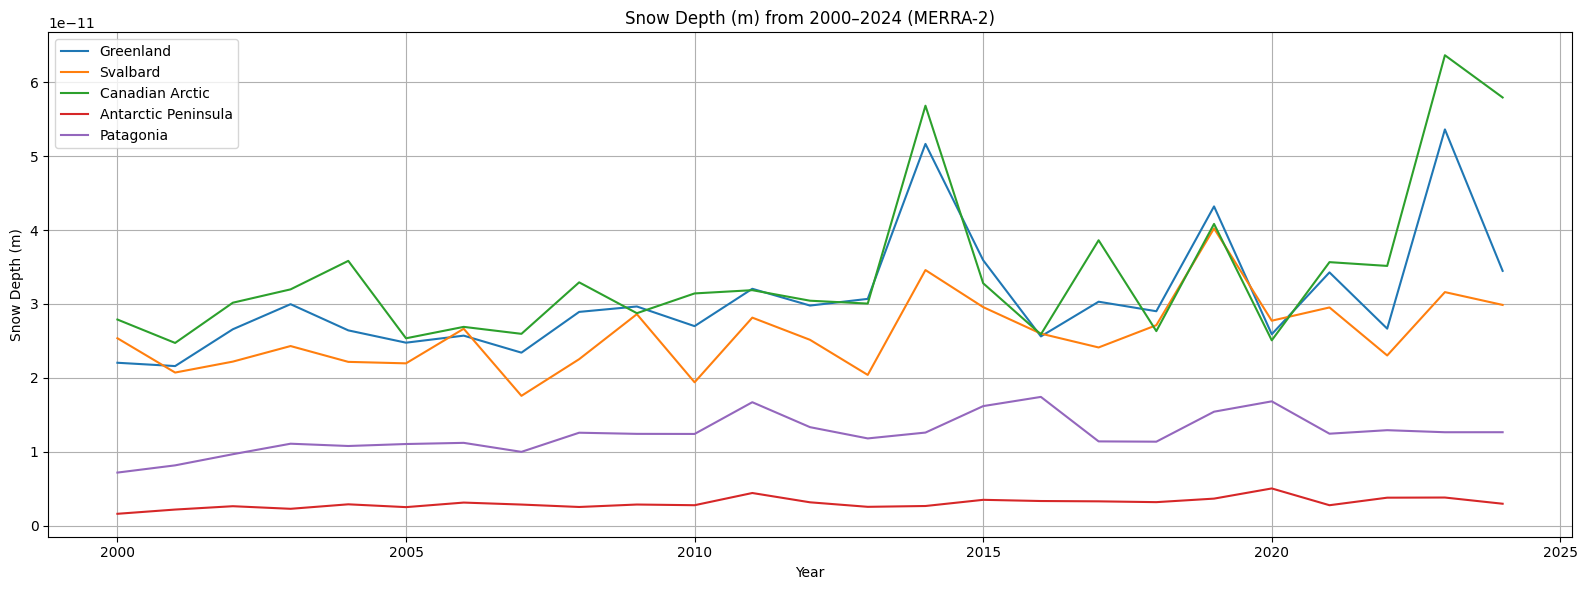

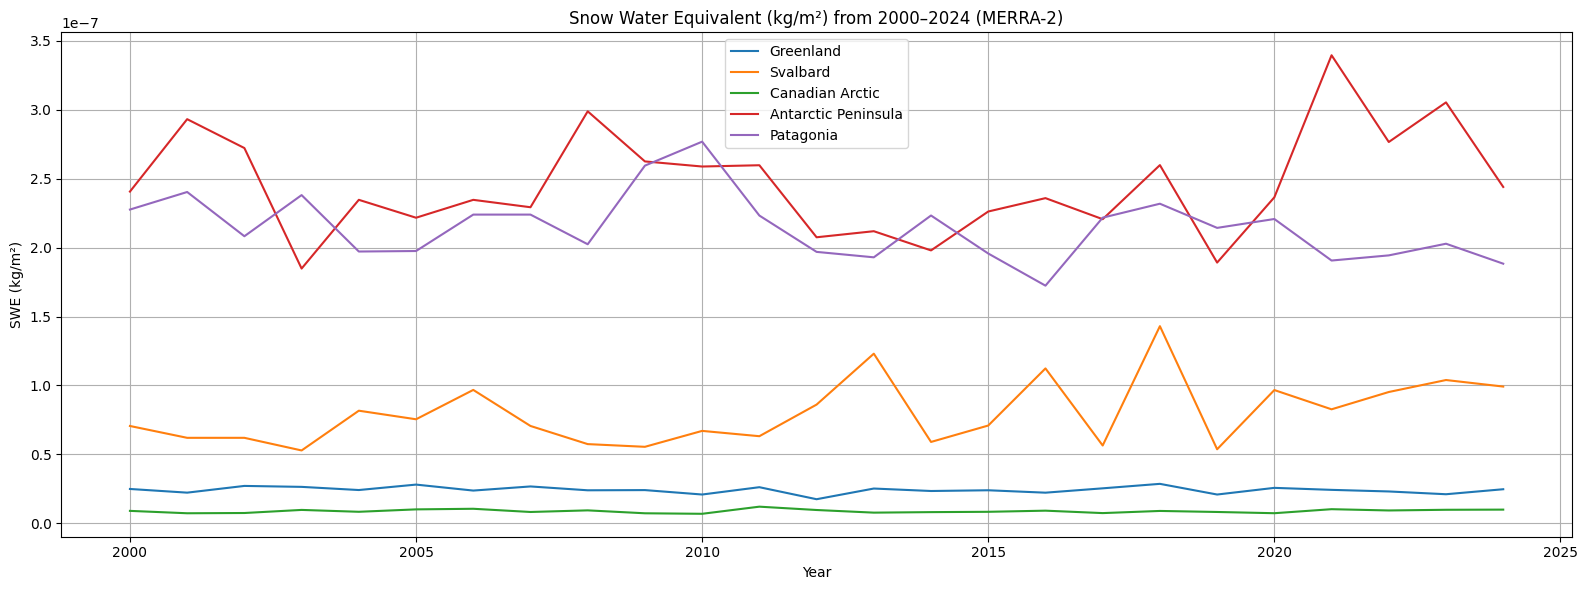

In [40]:
# Plotting Snow Depth
plt.figure(figsize=(16, 6))
for region in merra_df['Region'].unique():
    region_df = merra_df[merra_df['Region'] == region]
    plt.plot(region_df['Year'], region_df['SnowDepth_m'], label=region)

plt.title("Snow Depth (m) from 2000–2024 (MERRA-2)")
plt.xlabel("Year")
plt.ylabel("Snow Depth (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting SWE
plt.figure(figsize=(16, 6))
for region in merra_df['Region'].unique():
    region_df = merra_df[merra_df['Region'] == region]
    plt.plot(region_df['Year'], region_df['SWE_kg_per_m2'], label=region)

plt.title("Snow Water Equivalent (kg/m²) from 2000–2024 (MERRA-2)")
plt.xlabel("Year")
plt.ylabel("SWE (kg/m²)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()